In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

# Make sure notebook can import from src folder
sys.path.append(os.path.abspath("../src"))

# Plotting defaults
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [2]:
from data_pipeline.loaders import load_standardized_options, load_option_volume_wrds

px  = load_standardized_options("spy")
vol = load_option_volume_wrds("spy")

print("px cols:", px.columns.tolist()[:12])
display(px.head())

print("vol cols:", vol.columns.tolist()[:12])
display(vol.head())

px cols: ['date', 'underlying', 'put_call', 'expiry', 'strike', 'mid', 'last', 'iv', 'delta', 'gamma', 'vega', 'theta']


,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta
0,2005-01-10,SPY,C,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,2005-01-10,SPY,P,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341


vol cols: ['date', 'underlying', 'put_call', 'open_interest', 'volume']


,date,underlying,put_call,open_interest,volume
0,2005-01-10,SPY,NaN,0,241024
1,2005-01-10,SPY,C,0,131377
2,2005-01-10,SPY,P,0,109647
3,2005-01-11,SPY,NaN,217967,155058
4,2005-01-11,SPY,C,116214,72655


All raw files present & materialized ✅
⚠️ SPY has many NaNs — verify source file/columns. Proceeding anyway.
Market daily shape: (23278, 4)


/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["date"] = pd.to_datetime(out["date"], errors="coerce")
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline

,close_spy,close_gspc,vix,rate_10y
date,,,,
2025-09-21,NaN,NaN,15.45,4.14
2025-09-22,NaN,NaN,16.10,4.15
2025-09-23,NaN,NaN,16.64,4.12
2025-09-24,NaN,NaN,16.18,4.16
2025-09-25,NaN,NaN,16.74,NaN


Options snapshot shape: (103246, 14)


,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta,open_interest,volume
0,2005-01-10,SPY,C,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,131377.0
1,2005-01-10,SPY,P,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,109647.0
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229,0.0,131377.0
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660,0.0,109647.0
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341,0.0,131377.0


Vol surface shape: (1706460, 5)


,date,underlying,tenor_d,moneyness,iv
0,2005-01-10,SPY,30,-90,0.171916
1,2005-01-10,SPY,30,-85,0.142588
2,2005-01-10,SPY,30,-80,0.122542
3,2005-01-10,SPY,30,-75,0.116218
4,2005-01-10,SPY,30,-70,0.115786


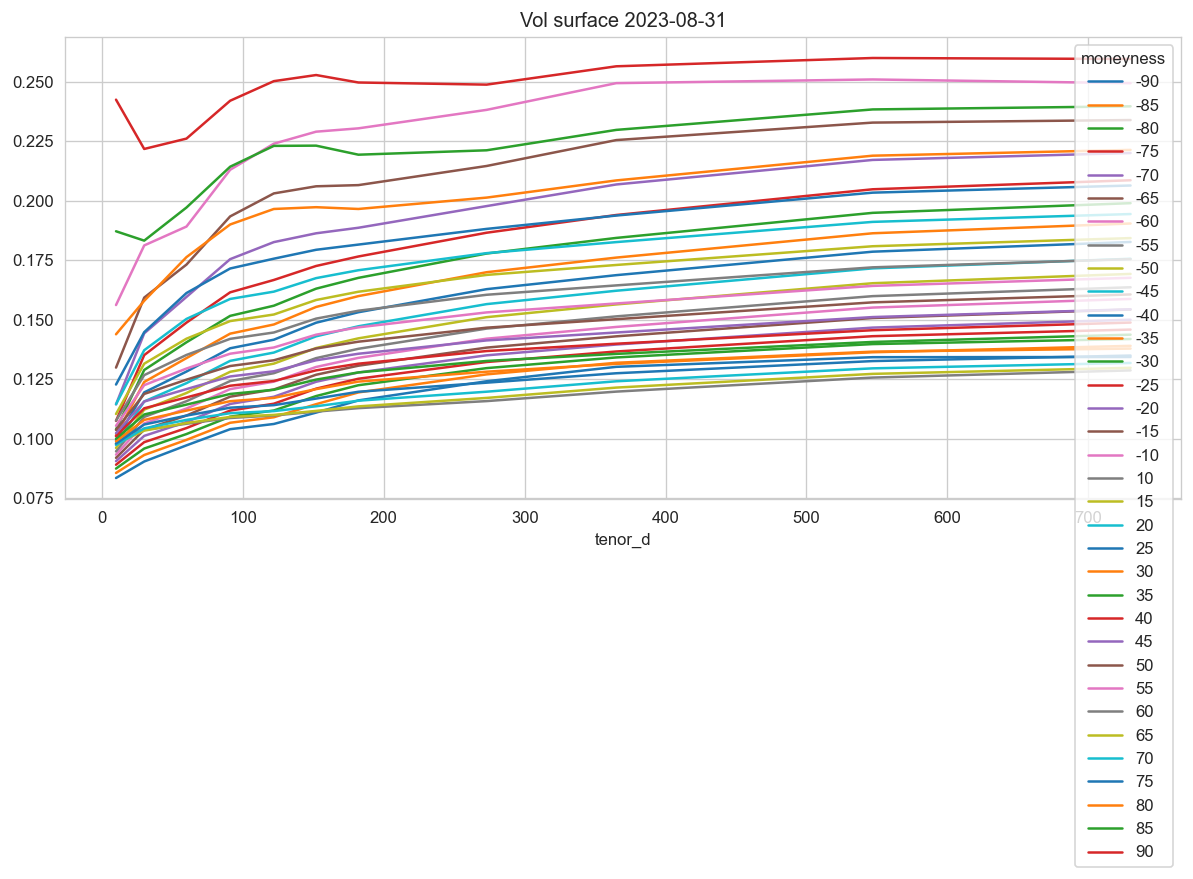

In [3]:
# 01_data_exploration.ipynb

# --- setup ---
import pandas as pd
import matplotlib.pyplot as plt

from data_pipeline.validate import validate_raw
from data_pipeline.builders import (
    build_market_daily,
    build_options_snapshot,
    build_vol_surface_long,
    build_market_plus_hvol_fwd,
)

# --- 0) check LFS files are materialized ---
validate_raw()   # will error if someone forgot `git lfs pull`

# --- 1) macro/market series ---
mkt = build_market_daily(save=False)
print("Market daily shape:", mkt.shape)
display(mkt.tail())

# --- 2) options snapshot (SPY) ---
opt_spy = build_options_snapshot("spy", save=False)
print("Options snapshot shape:", opt_spy.shape)
display(opt_spy.head())

# --- 3) vol surface (SPY) ---
surf_spy = build_vol_surface_long("spy", save=False)
print("Vol surface shape:", surf_spy.shape)
display(surf_spy.head())

# pivot tenor vs moneyness for the latest date
d0 = surf_spy['date'].max()
surf0 = surf_spy.query("date == @d0").pivot(
    index='tenor_d', columns='moneyness', values='iv'
)
surf0.plot(title=f"Vol surface {d0.date()}", figsize=(12,5))
plt.show()

In [4]:
opt_spy

,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta,open_interest,volume
0,2005-01-10,SPY,C,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,131377.0
1,2005-01-10,SPY,P,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,109647.0
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229,0.0,131377.0
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660,0.0,109647.0
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341,0.0,131377.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103241,2023-08-31,SPY,P,2024-08-30,470.293355,30.665202,30.665202,0.149578,-0.569648,0.008479,160.245994,-2.718230,14801715.0,4152975.0
103242,2023-08-31,SPY,C,2025-02-28,479.823396,34.368437,34.368437,0.160751,0.525911,0.004383,214.290135,-22.903168,6751654.0,3490295.0
103243,2023-08-31,SPY,P,2025-02-28,479.823396,40.379025,40.379025,0.155939,-0.589740,0.007348,189.943388,-0.864316,14801715.0,4152975.0
103244,2023-08-31,SPY,C,2025-08-30,486.964274,40.190556,40.190556,0.164426,0.528062,0.003675,245.306758,-20.561489,6751654.0,3490295.0


In [5]:
from data_pipeline.qc import coverage, assert_min_coverage

# --- ensure required columns exist ---
required = ["spy", "rate_10y"]

# try to find a plausible spot column and alias it to 'spy' if missing
if "spy" not in mkt.columns:
    spot_candidates = ["close", "adj_close", "px_close", "price", "spot", "spy_close"]
    spot_col = next((c for c in spot_candidates if c in mkt.columns), None)
    if spot_col is not None:
        mkt = mkt.copy()
        mkt["spy"] = mkt[spot_col]
        print(f"Aliased spot column '{spot_col}' -> 'spy'")
    else:
        print("⚠️ Could not find a spot column to alias to 'spy'. Available cols:", list(mkt.columns)[:15])

# gentle notice if 10y rate is missing
if "rate_10y" not in mkt.columns:
    print("⚠️ 'rate_10y' not found in mkt columns. QC will likely fail this requirement.")

# --- run coverage + assertion ---
cov = coverage(mkt)
print("Coverage summary:\n", cov)

# only assert for the columns that actually exist to avoid hard crashes
existing_required = [c for c in required if c in mkt.columns]
if existing_required:
    assert_min_coverage(mkt, existing_required, 0.60)
    print(f"✅ Minimum coverage OK for: {existing_required} (>= 60%)")
else:
    print("⚠️ None of the required columns were present; skipped assert_min_coverage.")

⚠️ Could not find a spot column to alias to 'spy'. Available cols: ['close_spy', 'close_gspc', 'vix', 'rate_10y']
Coverage summary:
                           first                 last non_na_ratio   rows
close_spy   1996-01-04 00:00:00  2025-08-29 00:00:00     0.465289  23278
close_gspc  1996-01-04 00:00:00  2025-08-29 00:00:00     0.465289  23278
vix         1990-01-02 00:00:00  2025-09-25 00:00:00     0.560658  23278
rate_10y    1962-01-02 00:00:00  2025-09-24 00:00:00     0.999957  23278
✅ Minimum coverage OK for: ['rate_10y'] (>= 60%)


In [6]:
# --- robust column detection ---
def pick_col(df, candidates):
    return next((c for c in candidates if c in df.columns), None)

spy_col  = pick_col(mkt, ["spy","close_spy","spot","close","adj_close","px_close"])
gspc_col = pick_col(mkt, ["close_gspc","spx","gspc","^GSPC","px_spx","close_spx"])
vix_col  = pick_col(mkt, ["vix","vix_close","iv_30d","implied_vol"])
rate_col = pick_col(mkt, ["rate_10y","ust10y","t10y","yield_10y"])

print("Detected columns:", {"spy": spy_col, "gspc": gspc_col, "vix": vix_col, "rate_10y": rate_col})

# rows where at least one series has data
mkt_any = mkt[mkt.notna().any(axis=1)]

# rows where ALL detected series are present
present_required = [c for c in [spy_col, gspc_col, vix_col, rate_col] if c is not None]
mkt_all = mkt.dropna(subset=present_required) if present_required else mkt.copy()

# start from the first valid SPY point (if we found a spy column)
if spy_col is not None and mkt[spy_col].first_valid_index() is not None:
    mkt_from_spy = mkt.loc[mkt[spy_col].first_valid_index():]
else:
    mkt_from_spy = mkt.copy()

print("Shapes:", {"mkt_any": mkt_any.shape, "mkt_all": mkt_all.shape, "mkt_from_spy": mkt_from_spy.shape})

Detected columns: {'spy': 'close_spy', 'gspc': 'close_gspc', 'vix': 'vix', 'rate_10y': 'rate_10y'}
Shapes: {'mkt_any': (23278, 4), 'mkt_all': (10831, 4), 'mkt_from_spy': (10858, 4)}


In [7]:
mkt_all

,close_spy,close_gspc,vix,rate_10y
date,,,,
1996-01-04,36.771626,617.700012,13.78,5.65
1996-01-05,36.697166,616.710022,13.58,5.69
1996-01-06,36.697166,616.710022,13.58,5.69
1996-01-07,36.697166,616.710022,13.58,5.69
1996-01-08,36.836807,618.460022,13.11,5.68
...,...,...,...,...
2025-08-25,640.693665,6439.319824,14.79,4.28
2025-08-26,643.376282,6465.939941,14.62,4.26
2025-08-27,644.842224,6481.399902,14.85,4.24


In [8]:
print("Vol surface shape:", surf_spy.shape)
print("Columns:", surf_spy.columns.tolist())
display(surf_spy.head())

print("\nNaN counts:")
display(surf_spy.isna().sum())

print("\nUnique tenors (days):", surf_spy['tenor_d'].unique()[:10])
print("Unique moneyness (sample):", surf_spy['moneyness'].unique()[:10])

Vol surface shape: (1706460, 5)
Columns: ['date', 'underlying', 'tenor_d', 'moneyness', 'iv']


,date,underlying,tenor_d,moneyness,iv
0,2005-01-10,SPY,30,-90,0.171916
1,2005-01-10,SPY,30,-85,0.142588
2,2005-01-10,SPY,30,-80,0.122542
3,2005-01-10,SPY,30,-75,0.116218
4,2005-01-10,SPY,30,-70,0.115786



NaN counts:


date          0
underlying    0
tenor_d       0
moneyness     0
iv            0
dtype: int64


Unique tenors (days): [ 30  60  91 122 152 182 273 365 547 730]
Unique moneyness (sample): [-90 -85 -80 -75 -70 -65 -60 -55 -50 -45]


In [9]:
# speed knobs
LAST_N_DAYS = 730  # 2 years; bump up/down as needed

# ensure datetime and filter recent window
opt_spy_fast = opt_spy.copy()
opt_spy_fast["date"] = pd.to_datetime(opt_spy_fast["date"], errors="coerce")
cutoff = opt_spy_fast["date"].max() - pd.Timedelta(days=LAST_N_DAYS)
opt_spy_fast = opt_spy_fast.loc[opt_spy_fast["date"] >= cutoff]

# keep only sensible rows for Greeks/prices
opt_spy_fast = opt_spy_fast[(opt_spy_fast["mid"] > 0) & opt_spy_fast["iv"].notna()]

# aggregate to daily medians by put/call (massive downsample)
agg_cols = ["mid", "iv", "delta", "gamma", "theta", "vega"]
daily = (
    opt_spy_fast
    .groupby(["date", "put_call"], as_index=False)[agg_cols]
    .median()
    .sort_values("date")
)
daily.head()

,date,put_call,mid,iv,delta,gamma,theta,vega
0,2021-08-31,C,19.623375,0.166622,0.531496,0.008429,-23.277608,114.865131
1,2021-08-31,P,19.405842,0.167870,-0.475931,0.008098,-23.736277,115.491141
2,2021-09-01,C,19.485111,0.165219,0.532320,0.008537,-22.565432,114.667552
3,2021-09-01,P,19.310162,0.167143,-0.475488,0.008121,-24.189450,115.426829
4,2021-09-02,C,19.409909,0.164155,0.532020,0.008569,-22.535528,115.570345


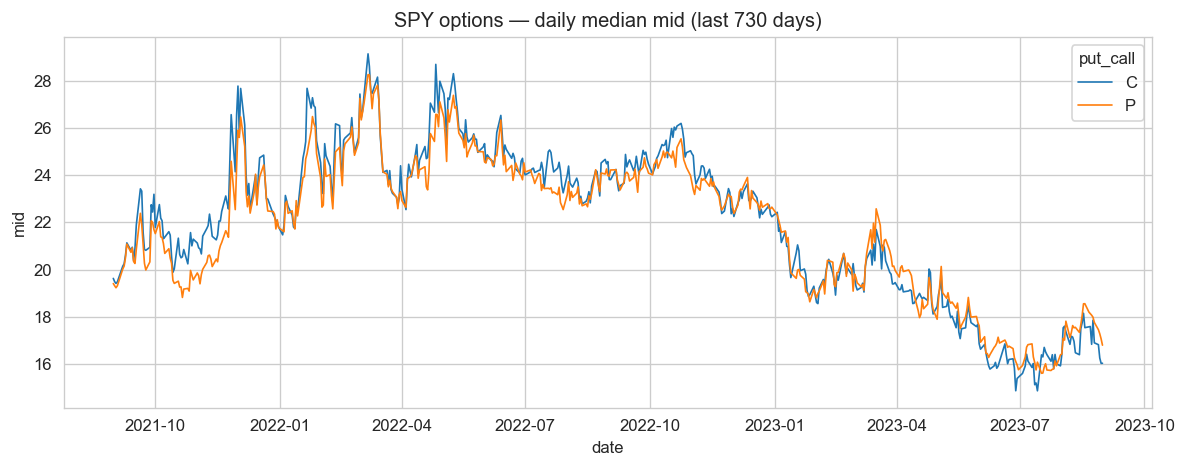

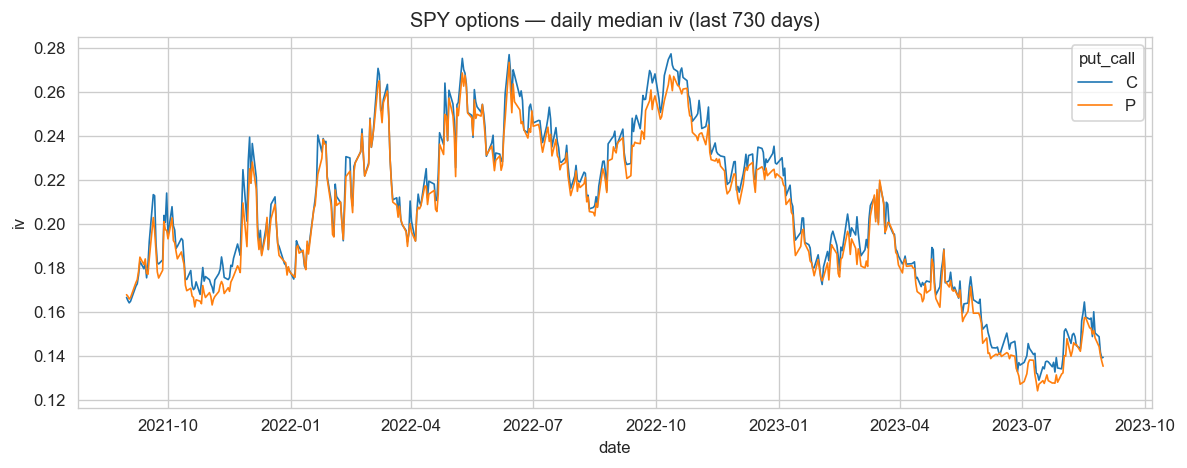

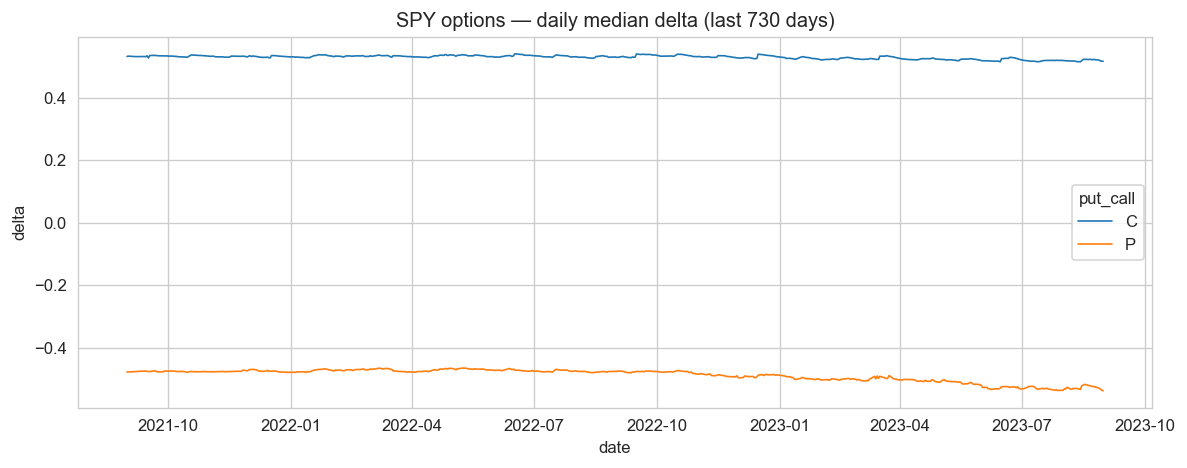

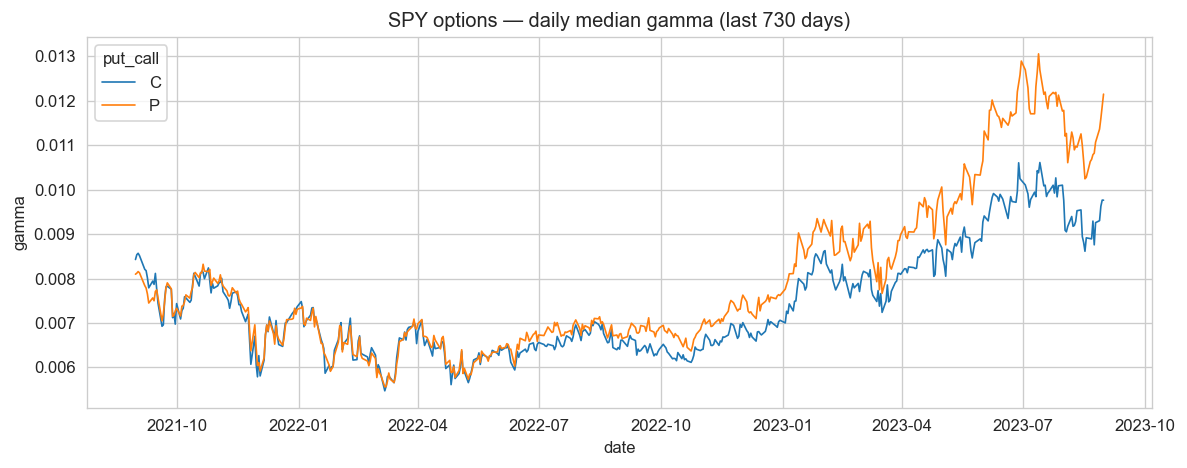

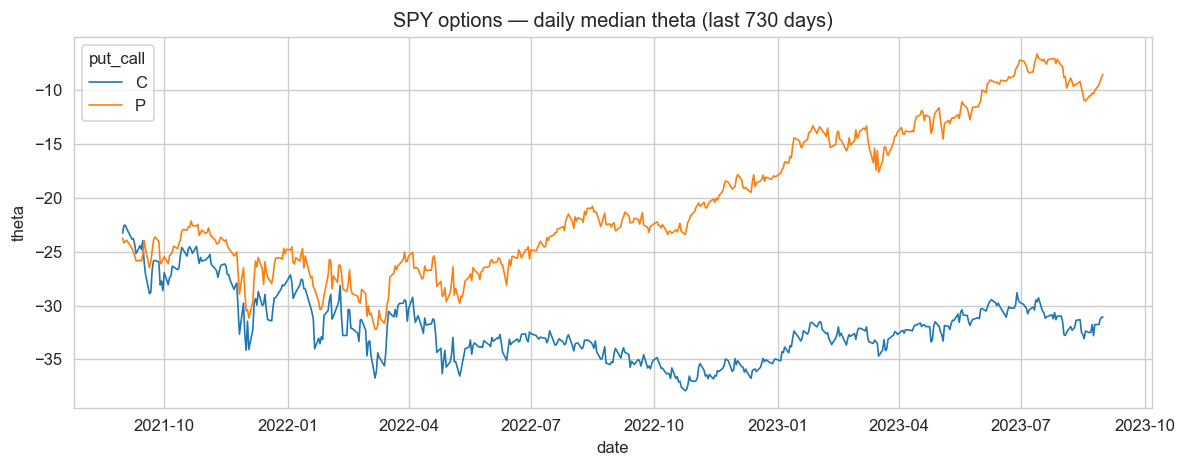

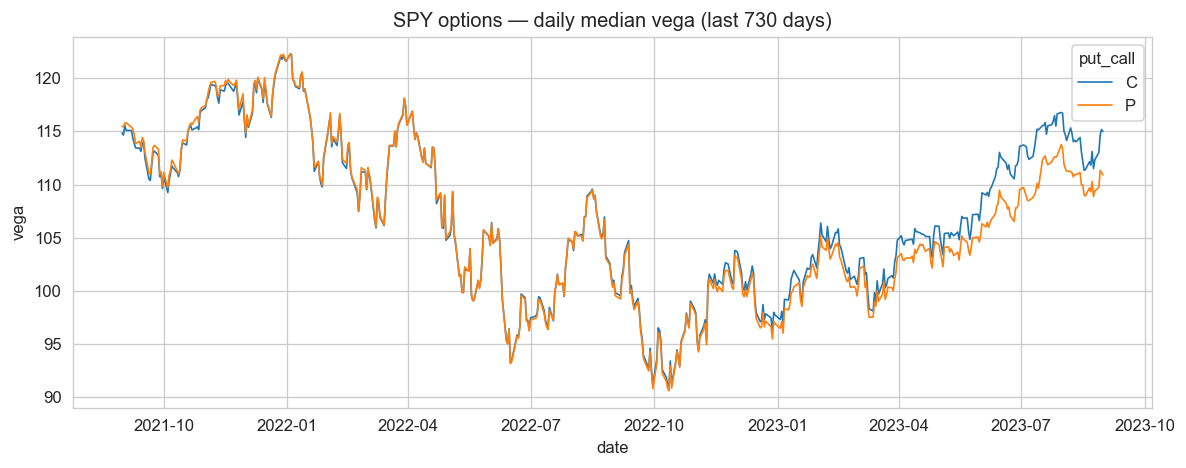

In [10]:
for col in ["mid", "iv", "delta", "gamma", "theta", "vega"]:
    plt.figure(figsize=(10, 4))
    plt.title(f"SPY options — daily median {col} (last {LAST_N_DAYS} days)")
    sns.lineplot(data=daily, x="date", y=col, hue="put_call", errorbar=None, lw=1)
    plt.xlabel("date"); plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [11]:
opt_spy.head()

,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta,open_interest,volume
0,2005-01-10,SPY,C,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,131377.0
1,2005-01-10,SPY,P,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,109647.0
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229,0.0,131377.0
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660,0.0,109647.0
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341,0.0,131377.0


In [12]:
# --- Clean SPY option data ---
print("Before cleaning:", len(opt_spy))

opt_spy_clean = opt_spy.copy()

# Drop rows with missing implied vol or Greeks
cols_to_check = ["iv", "delta", "gamma", "vega"]
opt_spy_clean = opt_spy_clean.dropna(subset=cols_to_check)

# Filter out zero or negative strikes/mid prices
opt_spy_clean = opt_spy_clean[
    (opt_spy_clean["strike"] > 0) &
    (opt_spy_clean["mid"] > 0)
]

# Ensure date is parsed
opt_spy_clean["date"] = pd.to_datetime(opt_spy_clean["date"], errors="coerce")

print("After cleaning:", len(opt_spy_clean))
display(opt_spy_clean.head())

Before cleaning: 103246
After cleaning: 100510


,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta,open_interest,volume
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229,0.0,131377.0
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660,0.0,109647.0
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341,0.0,131377.0
5,2005-01-10,SPY,P,2005-03-11,119.479045,2.397819,2.397819,0.122450,-0.501855,0.070335,19.130987,-5.942738,0.0,109647.0
6,2005-01-10,SPY,C,2005-04-11,119.203046,3.000457,3.000457,0.123830,0.527561,0.056166,23.425184,-7.642386,0.0,131377.0


In [13]:
# Quick range check for key columns
for col in ["iv", "delta", "gamma", "vega", "theta", "mid"]:
    if col in opt_spy_clean.columns:
        print(f"{col:>6} range: {opt_spy_clean[col].min():.4f}  to  {opt_spy_clean[col].max():.4f}")

    iv range: 0.0552  to  0.9896
 delta range: -0.6100  to  0.9000
 gamma range: 0.0026  to  0.4311
  vega range: 0.7547  to  260.3121
 theta range: -292.6890  to  0.9522
   mid range: 0.8001  to  58.8977


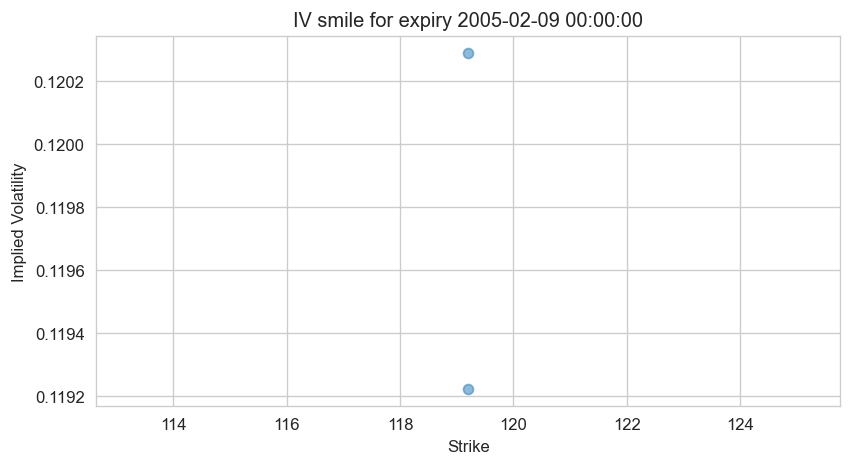

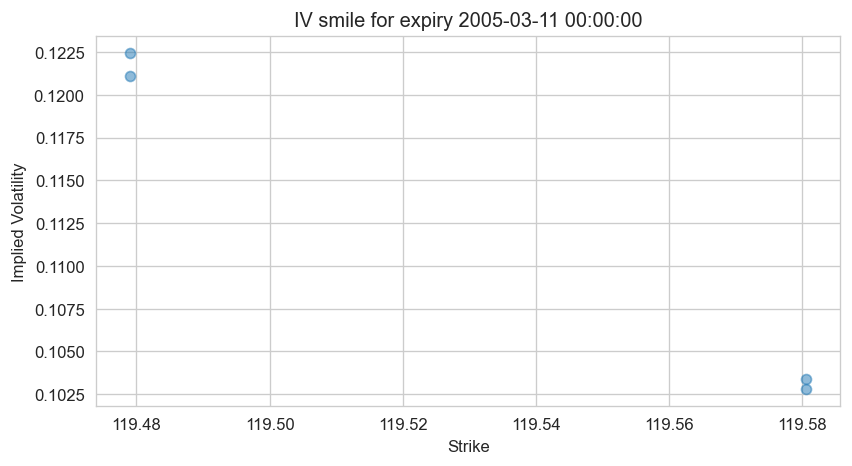

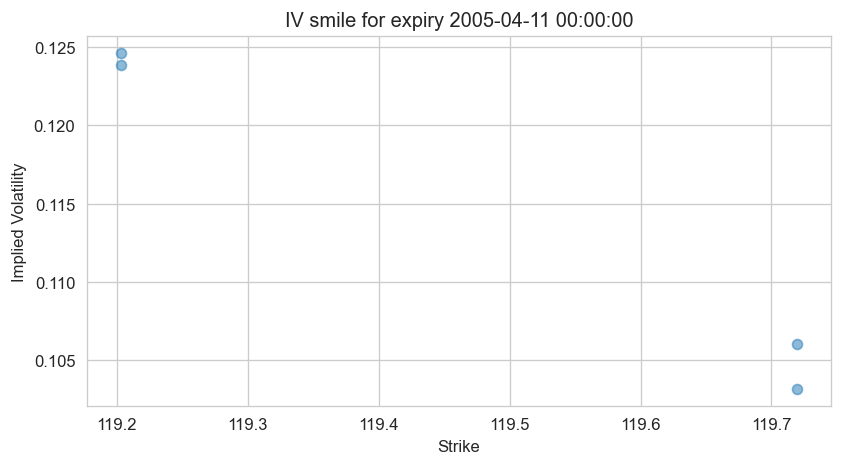

In [14]:
# Plot IV smiles for a few expiries
sample_expiries = opt_spy_clean["expiry"].dropna().unique()[:3]  # first 3 expiries
for exp in sample_expiries:
    data = opt_spy_clean[opt_spy_clean["expiry"] == exp]
    plt.figure(figsize=(8,4))
    plt.scatter(data["strike"], data["iv"], alpha=0.5)
    plt.title(f"IV smile for expiry {exp}")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.show()

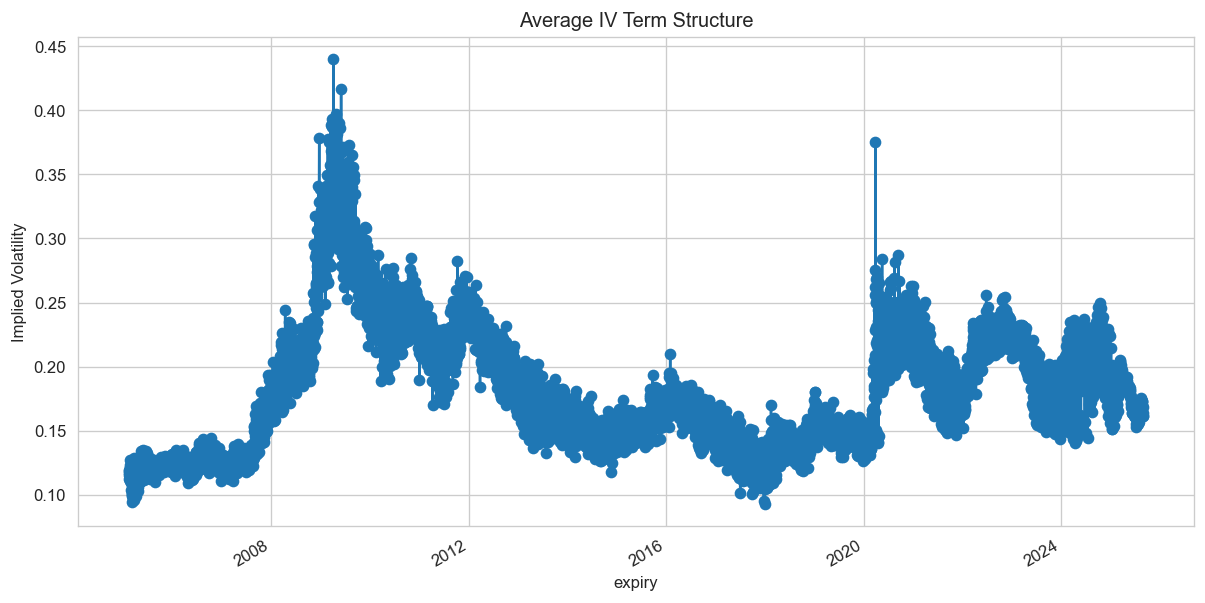

In [15]:
iv_term = opt_spy_clean.groupby("expiry")["iv"].mean().sort_index()
iv_term.plot(marker="o", title="Average IV Term Structure")
plt.ylabel("Implied Volatility")
plt.show()

In [16]:
#opt_spy_clean.to_parquet("../data/opt_spy_clean.parquet", index=False)
#print("Saved cleaned SPY options to parquet.")

# Cleaning Data

In [17]:
import pandas as pd
from pathlib import Path
from data_pipeline.config import PROCESSED_DIR, CLEANED, ALIGNED_SPX, ALIGNED_SPY, ALIGNED


In [18]:

# iterate files in PROCESSED_DIR (not the notebook CWD!)
for fpath in PROCESSED_DIR.iterdir():
    if not fpath.is_file():
        continue
    if "clean" in fpath.stem.lower() or fpath.name.startswith(".") or fpath.suffix not in [".csv", ".parquet"]:
        continue

    # read file
    if fpath.suffix == ".csv":
        df = pd.read_csv(fpath, parse_dates=True, index_col=0)
    else:
        df = pd.read_parquet(fpath)

    df_clean = df.dropna(how="any")

    # save to CLEANED dir
    out_csv = CLEANED / f"{fpath.stem}_clean.csv"
    out_parq = CLEANED / f"{fpath.stem}_clean.parquet"
    df_clean.to_csv(out_csv)
    df_clean.to_parquet(out_parq)

    print(f"✅ {fpath.name} cleaned -> {out_csv.name}, {out_parq.name}")


✅ vol_surface_spx.parquet cleaned -> vol_surface_spx_clean.csv, vol_surface_spx_clean.parquet
✅ market_extended_spx.parquet cleaned -> market_extended_spx_clean.csv, market_extended_spx_clean.parquet
✅ vol_surface_spy.parquet cleaned -> vol_surface_spy_clean.csv, vol_surface_spy_clean.parquet
✅ market_extended_spy.parquet cleaned -> market_extended_spy_clean.csv, market_extended_spy_clean.parquet
✅ options_snapshot_spx.parquet cleaned -> options_snapshot_spx_clean.csv, options_snapshot_spx_clean.parquet
✅ options_snapshot_spy.parquet cleaned -> options_snapshot_spy_clean.csv, options_snapshot_spy_clean.parquet


/var/folders/2p/b19f37nj6b98f824990xs99m0000gn/T/ipykernel_3247/3137597047.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fpath, parse_dates=True, index_col=0)


✅ options_snapshot_spy.csv cleaned -> options_snapshot_spy_clean.csv, options_snapshot_spy_clean.parquet


/var/folders/2p/b19f37nj6b98f824990xs99m0000gn/T/ipykernel_3247/3137597047.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fpath, parse_dates=True, index_col=0)


✅ options_snapshot_spx.csv cleaned -> options_snapshot_spx_clean.csv, options_snapshot_spx_clean.parquet


/var/folders/2p/b19f37nj6b98f824990xs99m0000gn/T/ipykernel_3247/3137597047.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fpath, parse_dates=True, index_col=0)


✅ vol_surface_spy.csv cleaned -> vol_surface_spy_clean.csv, vol_surface_spy_clean.parquet


/var/folders/2p/b19f37nj6b98f824990xs99m0000gn/T/ipykernel_3247/3137597047.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fpath, parse_dates=True, index_col=0)


✅ vol_surface_spx.csv cleaned -> vol_surface_spx_clean.csv, vol_surface_spx_clean.parquet
✅ market_daily.csv cleaned -> market_daily_clean.csv, market_daily_clean.parquet
✅ market_extended_spy.csv cleaned -> market_extended_spy_clean.csv, market_extended_spy_clean.parquet
✅ market_daily.parquet cleaned -> market_daily_clean.csv, market_daily_clean.parquet
✅ market_extended_spx.csv cleaned -> market_extended_spx_clean.csv, market_extended_spx_clean.parquet


In [19]:
# sanity checks
print("CWD        :", Path.cwd())
print("PROCESSED  :", PROCESSED_DIR.resolve())
print("CLEANED    :", CLEANED.resolve())

# build the full path from config (NOT a string literal)
fp = CLEANED / "market_extended_spx_clean.parquet"
print("Reading    :", fp.resolve())

if not fp.exists():
    # helpful debug: show what's actually in the folder
    print("Available in PROCESSED_DIR:")
    for p in sorted(PROCESSED_DIR.glob("*spx*")):
        print(" -", p.name)
    raise FileNotFoundError(fp)

market_extended_clean_spx = pd.read_parquet(fp)
display(market_extended_clean_spx.head())


CWD        : /Users/ya/Desktop/deep-hedging-rl/notebooks
PROCESSED  : /Users/ya/Desktop/deep-hedging-rl/data/processed
CLEANED    : /Users/ya/Desktop/deep-hedging-rl/data/processed/cleaned
Reading    : /Users/ya/Desktop/deep-hedging-rl/data/processed/cleaned/market_extended_spx_clean.parquet


,close_spy,close_gspc,vix,rate_10y,hvol_10d,hvol_14d,hvol_30d,hvol_60d,hvol_91d,hvol_122d,hvol_152d,hvol_182d,hvol_273d,hvol_365d,hvol_547d,hvol_730d,hvol_1825d,fwd_front
date,,,,,,,,,,,,,,,,,,
1996-01-04,36.771626,617.700012,13.78,5.65,0.066934,0.06226,0.099637,0.091679,0.088536,0.082083,0.07694,0.078675,0.0823,0.078532,0.08396,0.089418,0.102954,619.154402
1996-01-04,36.771626,617.700012,13.78,5.65,0.066934,0.06226,0.099637,0.091679,0.088536,0.082083,0.07694,0.078675,0.0823,0.078532,0.08396,0.089418,0.102954,620.656417
1996-01-04,36.771626,617.700012,13.78,5.65,0.066934,0.06226,0.099637,0.091679,0.088536,0.082083,0.07694,0.078675,0.0823,0.078532,0.08396,0.089418,0.102954,621.805572
1996-01-04,36.771626,617.700012,13.78,5.65,0.066934,0.06226,0.099637,0.091679,0.088536,0.082083,0.07694,0.078675,0.0823,0.078532,0.08396,0.089418,0.102954,626.574252
1996-01-04,36.771626,617.700012,13.78,5.65,0.066934,0.06226,0.099637,0.091679,0.088536,0.082083,0.07694,0.078675,0.0823,0.078532,0.08396,0.089418,0.102954,630.078895


In [20]:
# Load pipeline output
df = mkt.copy()
df_clean = mkt_all.copy()  # choose your preferred cleaning method

# Save clean versions
out_csv = CLEANED / "market_daily_clean.csv"
out_parq = CLEANED / "market_daily_clean.parquet"

df_clean.to_csv(out_csv)
df_clean.to_parquet(out_parq)

display(df_clean)
display(df)

,close_spy,close_gspc,vix,rate_10y
date,,,,
1996-01-04,36.771626,617.700012,13.78,5.65
1996-01-05,36.697166,616.710022,13.58,5.69
1996-01-06,36.697166,616.710022,13.58,5.69
1996-01-07,36.697166,616.710022,13.58,5.69
1996-01-08,36.836807,618.460022,13.11,5.68
...,...,...,...,...
2025-08-25,640.693665,6439.319824,14.79,4.28
2025-08-26,643.376282,6465.939941,14.62,4.26
2025-08-27,644.842224,6481.399902,14.85,4.24


,close_spy,close_gspc,vix,rate_10y
date,,,,
1962-01-02,NaN,NaN,NaN,4.06
1962-01-03,NaN,NaN,NaN,4.03
1962-01-04,NaN,NaN,NaN,3.99
1962-01-05,NaN,NaN,NaN,4.02
1962-01-06,NaN,NaN,NaN,4.02
...,...,...,...,...
2025-09-21,NaN,NaN,15.45,4.14
2025-09-22,NaN,NaN,16.10,4.15
2025-09-23,NaN,NaN,16.64,4.12


In [21]:
from data_pipeline.clean_data import build_combined

# SPX goes back to ~1996
build_combined(symbol="spx", start_date="1996-01-01")

# SPY starts ~2005
build_combined(symbol="spy", start_date="2005-01-01")


✅ options_snapshot_spx: 6,963 rows, 20 cols
✅ vol_surface_spx: 6,963 rows, 11 cols
✅ market_extended_spx: 6,963 rows, 24 cols
✅ market_daily: 10,831 rows, 6 cols

📦 SPX combined saved:
   - /Users/ya/Desktop/deep-hedging-rl/data/processed/aligned/spx/combined_spx_all.csv
   - /Users/ya/Desktop/deep-hedging-rl/data/processed/aligned/spx/combined_spx_all.parquet
   Shape: 31,720 rows × 44 cols
   Date range: 1996-01-04 00:00:00 → 2025-08-29 00:00:00

Row counts by source:
source
market_daily            10831
options_snapshot_spx     6963
vol_surface_spx          6963
market_extended_spx      6963
✅ options_snapshot_spy: 4,692 rows, 20 cols
✅ vol_surface_spy: 4,693 rows, 11 cols
✅ market_extended_spy: 4,693 rows, 24 cols
✅ market_daily: 7,546 rows, 6 cols

📦 SPY combined saved:
   - /Users/ya/Desktop/deep-hedging-rl/data/processed/aligned/spy/combined_spy_all.csv
   - /Users/ya/Desktop/deep-hedging-rl/data/processed/aligned/spy/combined_spy_all.parquet
   Shape: 21,624 rows × 44 cols
   D

In [22]:
fp = ALIGNED_SPX / "combined_spx_all.parquet"
print("Reading    :", fp.resolve())

combined_spx_all = pd.read_parquet(fp)
display(combined_spx_all.head())

Reading    : /Users/ya/Desktop/deep-hedging-rl/data/processed/aligned/spx/combined_spx_all.parquet


,source,date,Unnamed: 0,underlying,put_call,expiry,strike,mid,last,iv,...,hvol_273d,hvol_365d,hvol_547d,hvol_730d,hvol_1825d,fwd_front,close_spy_y,close_gspc_y,vix_y,rate_10y_y
0,options_snapshot_spx,1996-01-04,2.0,SPX,C,1996-02-03,620.049338,6.983696,6.983696,0.098942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,options_snapshot_spx,1996-01-05,35.0,SPX,P,1996-07-05,626.804475,21.166795,21.166795,0.123220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,options_snapshot_spx,1996-01-08,56.0,SPX,C,1996-07-08,629.710680,20.302191,20.302191,0.117640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,options_snapshot_spx,1996-01-09,80.0,SPX,C,1996-10-08,620.574487,27.254511,27.254511,0.132543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,options_snapshot_spx,1996-01-10,102.0,SPX,C,1996-10-09,612.036956,26.917740,26.917740,0.132763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from pathlib import Path
from data_pipeline.config import ROOT, PROCESSED_DIR, CLEANED
import pandas as pd

print("CWD       :", Path.cwd())
print("ROOT      :", ROOT)
print("PROCESSED :", PROCESSED_DIR.resolve())
print("CLEANED   :", CLEANED.resolve())

# 1) list a couple files we expect
print("\nContents of PROCESSED (head):")
for p in sorted(PROCESSED_DIR.glob("*"))[:8]:
    print(" -", p.name)

# 2) read from PROCESSED using config path
fp = PROCESSED_DIR / "market_extended_spx.parquet"
assert fp.exists(), f"Missing file: {fp}"
df = pd.read_parquet(fp)
print("\nLoaded rows:", len(df), "cols:", list(df.columns)[:6], "...")

# 3) write to CLEANED using config path (temp file)
tmp_csv  = CLEANED / "_smoke_tmp.csv"
tmp_parq = CLEANED / "_smoke_tmp.parquet"
df.head(50).to_csv(tmp_csv, index=False)
df.head(50).to_parquet(tmp_parq)
print("\nWrote:", tmp_csv.name, "and", tmp_parq.name)

assert tmp_csv.exists() and tmp_parq.exists()
(tmp_csv).unlink(); (tmp_parq).unlink()
print("✅ Path round-trip OK (and temp files removed).")


CWD       : /Users/ya/Desktop/deep-hedging-rl/notebooks
ROOT      : /Users/ya/Desktop/deep-hedging-rl
PROCESSED : /Users/ya/Desktop/deep-hedging-rl/data/processed
CLEANED   : /Users/ya/Desktop/deep-hedging-rl/data/processed/cleaned

Contents of PROCESSED (head):
 - .DS_Store
 - aligned
 - cleaned
 - market_daily.csv
 - market_daily.parquet
 - market_daily_clean.csv
 - market_daily_clean.parquet
 - market_extended_spx.csv

Loaded rows: 166200 cols: ['close_spy', 'close_gspc', 'vix', 'rate_10y', 'hvol_10d', 'hvol_14d'] ...

Wrote: _smoke_tmp.csv and _smoke_tmp.parquet
✅ Path round-trip OK (and temp files removed).
